In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision

In [2]:
pip install torch

In [3]:
batch_size = 64
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.SVHN(root='./data', split='train', download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


100%|██████████| 182040794/182040794 [00:07<00:00, 24153811.83it/s]


In [4]:
test_dataset = datasets.SVHN(root='./data', split='test', download=True, transform=transform)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 64275384/64275384 [00:02<00:00, 24441834.38it/s]


In [5]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.encoder(x))
        x = self.activation(self.decoder(x))
        return x

In [7]:
input_size = 32 * 32 * 3  
hidden_size = 64  
batch_size = 64
learning_rate = 0.001
num_epochs = 10
save_path = 'best_autoencoder.pth'

Epoch [1/10], Avg Train Loss: 0.1483, Avg Val Loss: 0.1343
Epoch [2/10], Avg Train Loss: 0.1312, Avg Val Loss: 0.1291
Epoch [3/10], Avg Train Loss: 0.1270, Avg Val Loss: 0.1257
Epoch [4/10], Avg Train Loss: 0.1239, Avg Val Loss: 0.1229
Epoch [5/10], Avg Train Loss: 0.1215, Avg Val Loss: 0.1210
Epoch [6/10], Avg Train Loss: 0.1196, Avg Val Loss: 0.1192
Epoch [7/10], Avg Train Loss: 0.1181, Avg Val Loss: 0.1182
Epoch [8/10], Avg Train Loss: 0.1171, Avg Val Loss: 0.1174
Epoch [9/10], Avg Train Loss: 0.1163, Avg Val Loss: 0.1163
Epoch [10/10], Avg Train Loss: 0.1157, Avg Val Loss: 0.1159


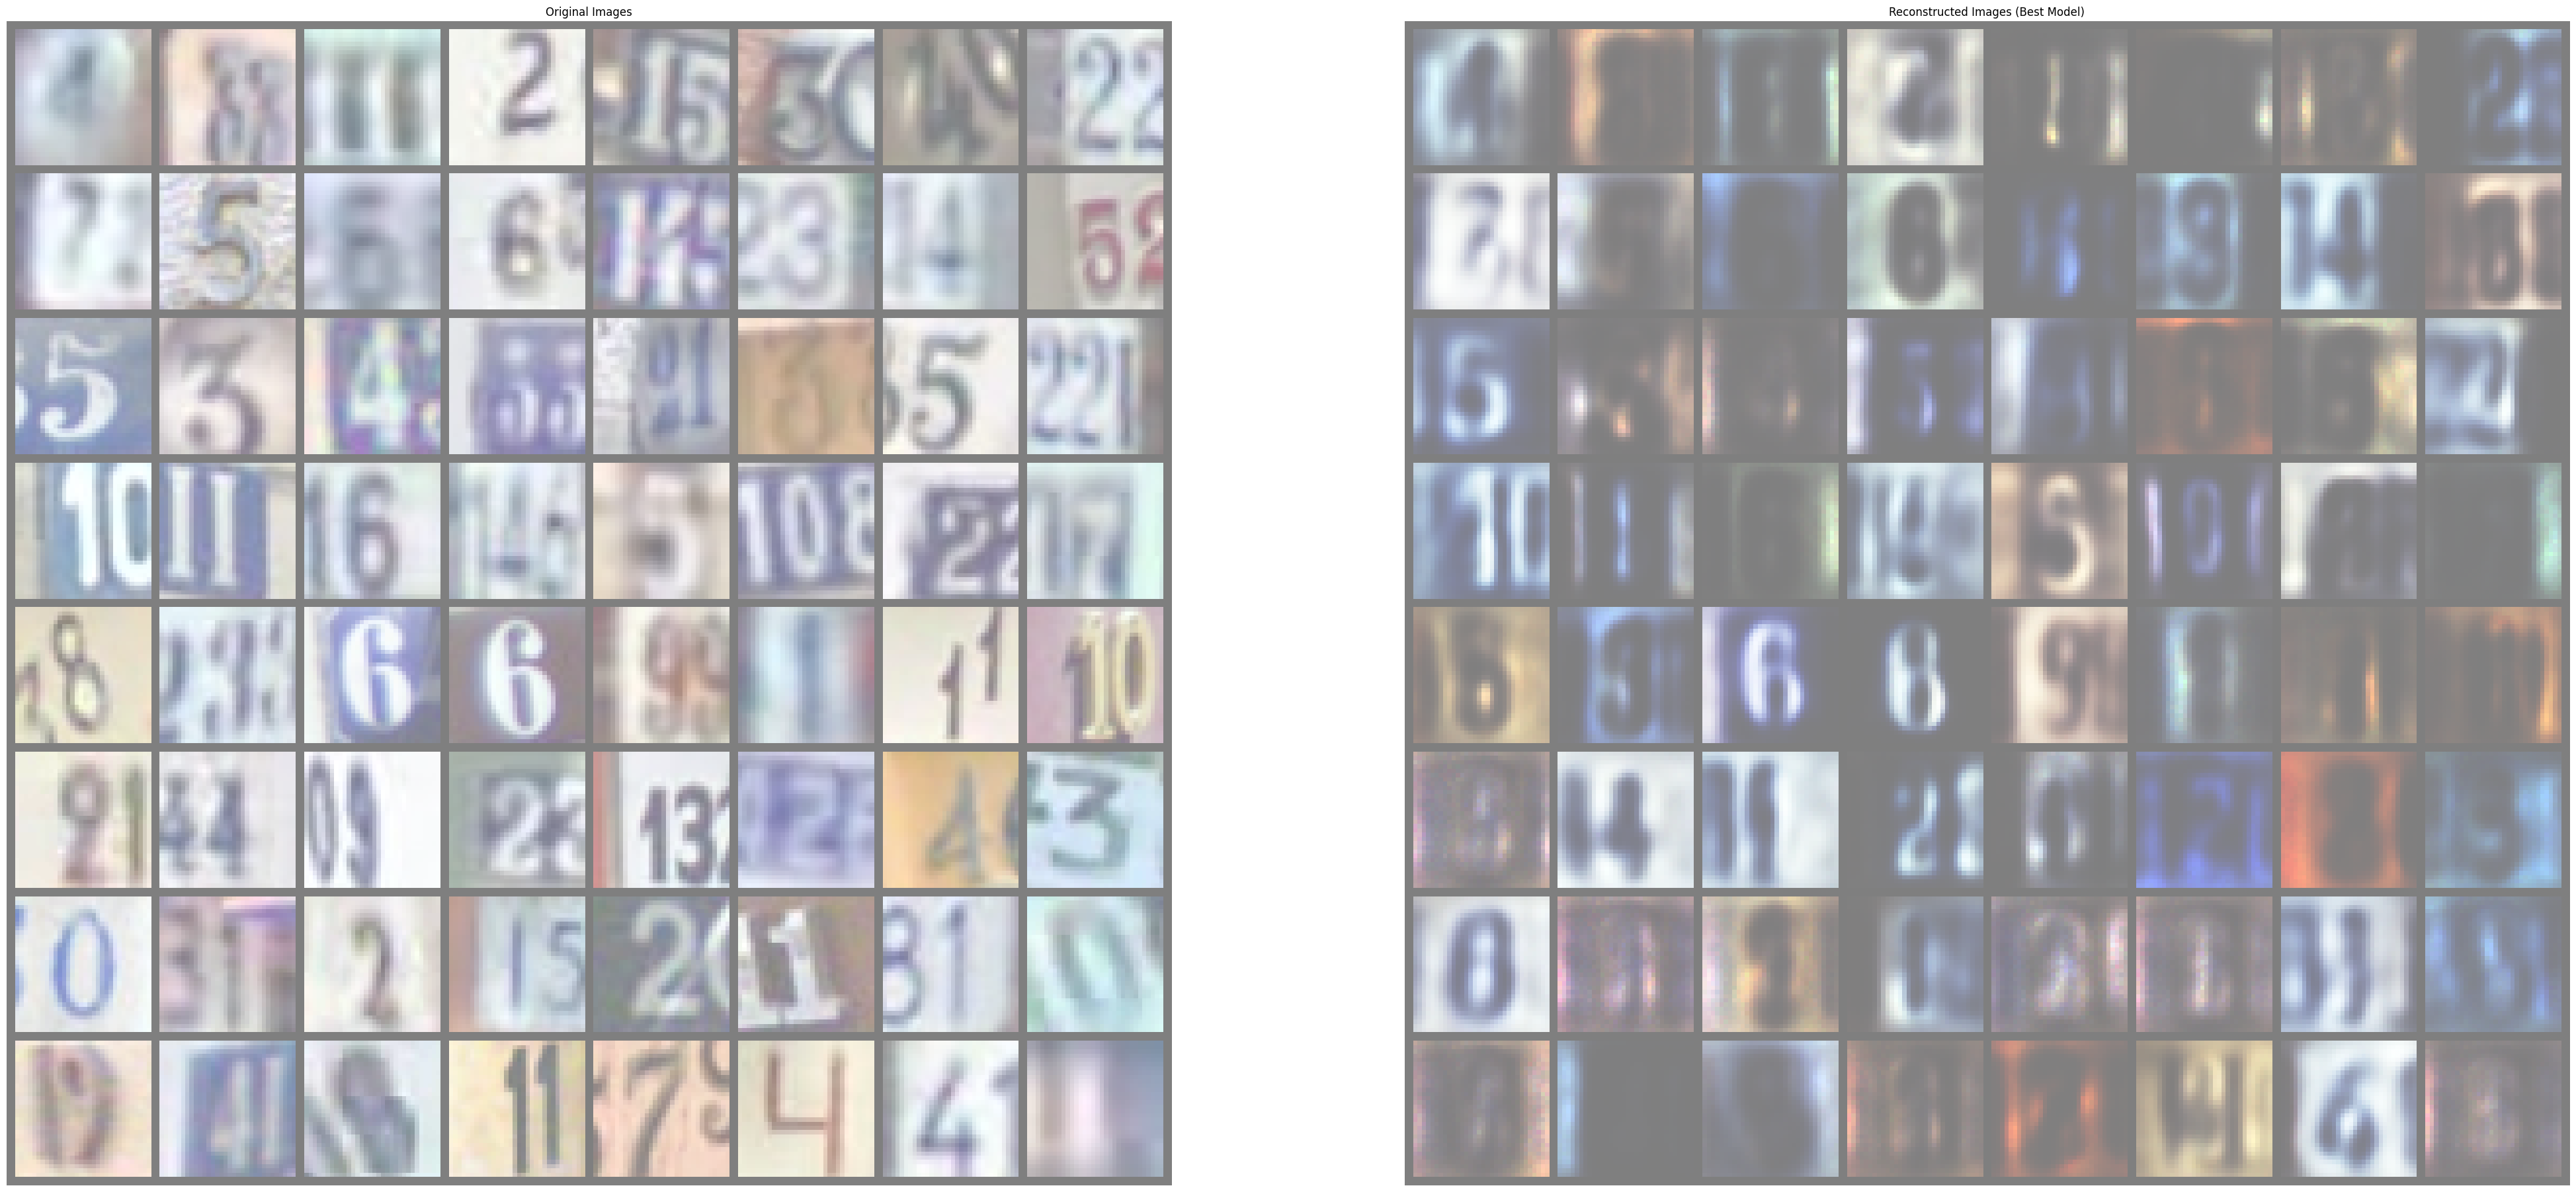

In [9]:
model = Autoencoder(input_size, hidden_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

best_val_loss = float('inf')

train_losses=[]
val_losses=[]

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0

    for data, _ in train_loader:
        data = data.view(-1, input_size)  
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for data, _ in val_loader:
            data = data.view(-1, input_size)
            outputs = model(data)
            loss = criterion(outputs, data)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Avg Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}')

    train_losses.append(total_train_loss)
    val_losses.append(total_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), save_path)

best_model = Autoencoder(input_size, hidden_size)
best_model.load_state_dict(torch.load(save_path))

sample_data, _ = next(iter(val_loader))
sample_data = sample_data.view(-1, input_size)
reconstructed_data = best_model(sample_data)

def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

plt.figure(figsize=(50, 50))
plt.subplot(1, 2, 1)
imshow(torchvision.utils.make_grid(sample_data.view(-1, 3, 32, 32).cpu(), nrow=8, scale_each=True, normalize=True))
plt.title('Original Images')

plt.subplot(1, 2, 2)
imshow(torchvision.utils.make_grid(reconstructed_data.view(-1, 3, 32, 32).cpu(), nrow=8, scale_each=True, normalize=True))
plt.title('Reconstructed Images (Best Model)')

plt.show()



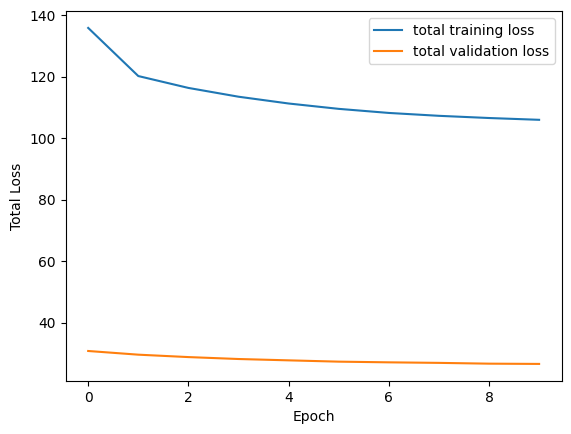

In [10]:
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)
plt.plot(np.array(range(num_epochs)), train_losses, label = 'total training loss')
plt.plot(np.array(range(num_epochs)), val_losses, label = 'total validation loss')
plt.ylabel('Total Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [11]:
class EnhancedAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_sizes, activation_function):
        super(EnhancedAutoencoder, self).__init__()

        encoder_layers = []
        decoder_layers = []

        prev_size = input_size
        for size in hidden_sizes:
            encoder_layers.append(nn.Linear(prev_size, size))
            encoder_layers.append(activation_function())
            prev_size = size

        self.encoder = nn.Sequential(*encoder_layers)

        for size in reversed(hidden_sizes):
            decoder_layers.append(nn.Linear(size, prev_size))
            decoder_layers.append(activation_function())
            prev_size = size

        decoder_layers.append(nn.Linear(prev_size, input_size))
        decoder_layers.append(nn.Sigmoid())

        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [17]:
input_size = 32 * 32 * 3  
hidden_sizes = [256, 128, 64, 32, 16]  
batch_size = 64
learning_rate = 0.002
num_epochs = 1
activation_function = nn.ReLU

Epoch [1/1], Avg Train Loss: 0.1143, Avg Val Loss: 0.1151


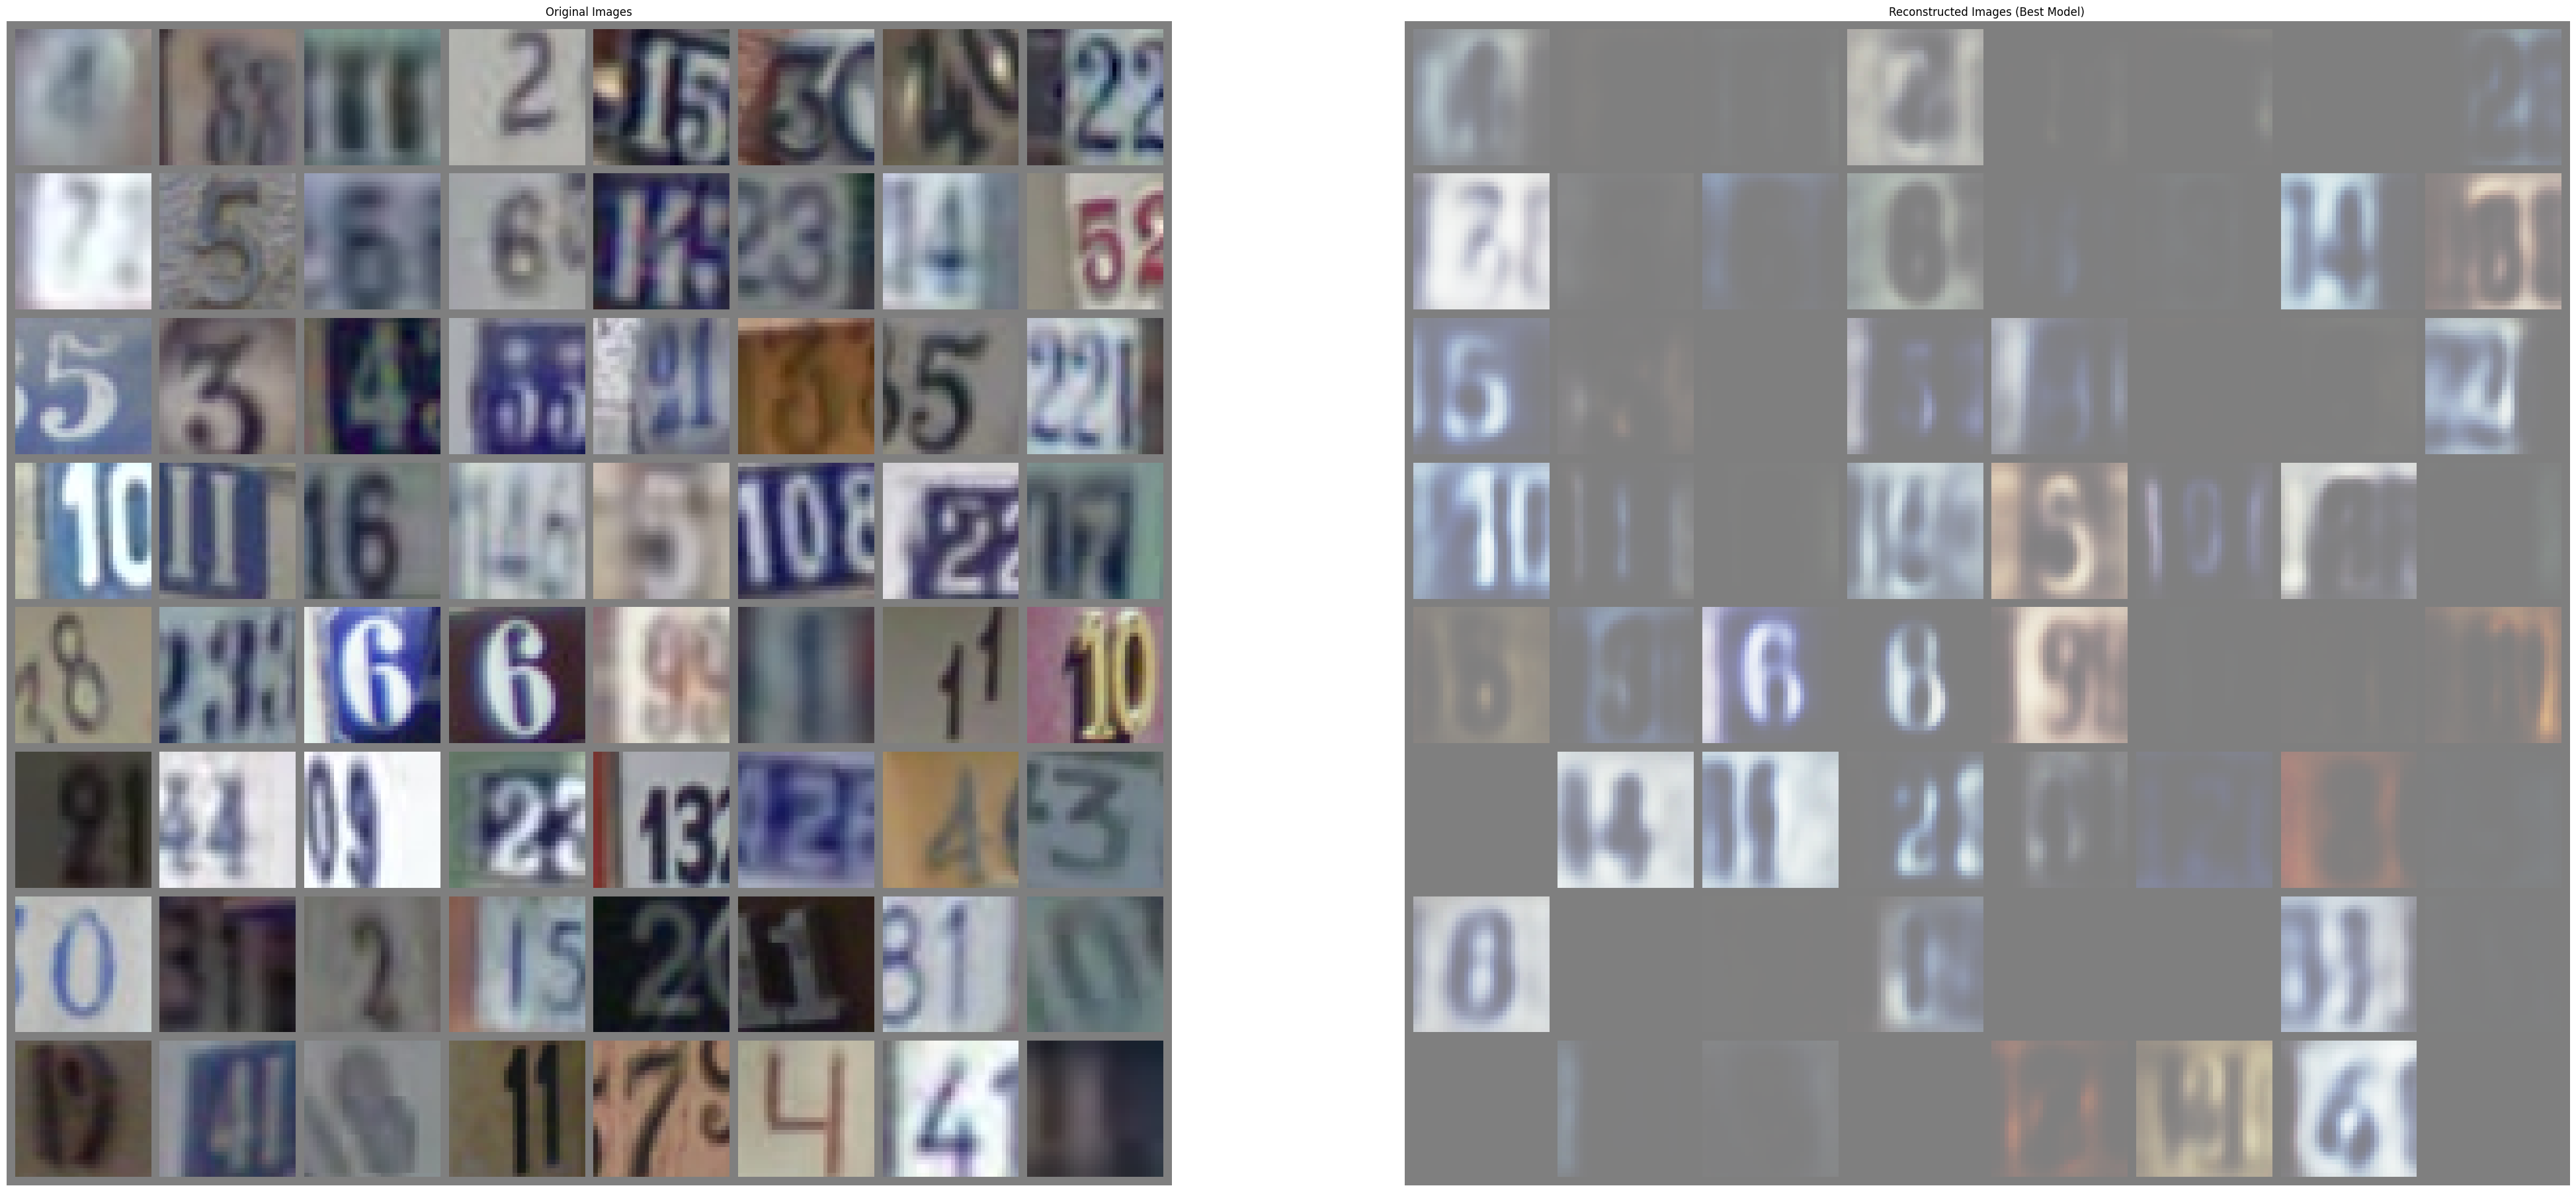

In [19]:
model2 = EnhancedAutoencoder(input_size, hidden_sizes, activation_function)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


train_losses1=[]
valid_losses1=[]

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0

    for data, _ in train_loader:
        data = data.view(-1, input_size)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for data, _ in val_loader:
            data = data.view(-1, input_size)
            outputs = model(data)
            loss = criterion(outputs, data)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Avg Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}')

    train_losses1.append(total_train_loss)
    valid_losses1.append(total_val_loss)

def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

plt.figure(figsize=(50, 50))
plt.subplot(1, 2, 1)
imshow(torchvision.utils.make_grid(sample_data.view(batch_size, 3, 32, 32).cpu()))
plt.title('Original Images')

plt.subplot(1, 2, 2)
imshow(torchvision.utils.make_grid(reconstructed_data.view(batch_size, 3, 32, 32).cpu()))
plt.title('Reconstructed Images (Best Model)')

plt.show()


In [ ]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

total_test_loss = 0.0

best_model.eval()

with torch.no_grad():
    for data, _ in test_loader:
        data = data.view(-1, input_size)
        outputs = best_model(data)
        loss = criterion(outputs, data)
        total_test_loss += loss.item()

avg_test_loss = total_test_loss / len(test_loader)
print(f'Average Test Loss: {avg_test_loss:.4f}')

sample_test_data, _ = next(iter(test_loader))
sample_test_data = sample_test_data.view(-1, input_size)
reconstructed_test_data = best_model(sample_test_data)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
imshow(torchvision.utils.make_grid(sample_test_data.view(-1, 3, 32, 32).cpu(), nrow=8, scale_each=True, normalize=True))
plt.title('Original Test Images')

plt.subplot(1, 2, 2)
imshow(torchvision.utils.make_grid(reconstructed_test_data.view(-1, 3, 32, 32).cpu(), nrow=8, scale_each=True, normalize=True))
plt.title('Reconstructed Test Images')

plt.show()


In [ ]:
input_size = 32 * 32 * 3  
hidden_size = 32 
batch_size = 10
learning_rate = 0.005
num_epochs = 5
save_path = 'best_autoencoder.pth' 

In [ ]:
model = Autoencoder(input_size, hidden_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0

    for data, _ in train_loader:
        data = data.view(-1, input_size)  
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for data, _ in val_loader:
            data = data.view(-1, input_size)
            outputs = model(data)
            loss = criterion(outputs, data)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Avg Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), save_path)

best_model = Autoencoder(input_size, hidden_size)
best_model.load_state_dict(torch.load(save_path))

sample_data, _ = next(iter(val_loader))
sample_data = sample_data.view(-1, input_size)
reconstructed_data = best_model(sample_data)

def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

plt.figure(figsize=(50, 50))
plt.subplot(1, 2, 1)
imshow(torchvision.utils.make_grid(sample_data.view(-1, 3, 32, 32).cpu(), nrow=8, scale_each=True, normalize=True))
plt.title('Original Images')

plt.subplot(1, 2, 2)
imshow(torchvision.utils.make_grid(reconstructed_data.view(-1, 3, 32, 32).cpu(), nrow=8, scale_each=True, normalize=True))
plt.title('Reconstructed Images (Best Model)')

plt.show()